In [56]:
import pandas as pd 
import numpy as np
from scipy import stats
from linearmodels import PanelOLS,RandomEffects

## Archivo en Long Format

In [57]:
df=pd.read_csv('panel_limpio.csv',sep=';')
df

,Pais,Anio,Tasa_desempleo,PBI,Consumo_privado,Gasto_publico,Inflacion,Inv_Extranjera_D,Salida_Net_Cap
0,Chile,1986,0.087,0.00316,0.00339,0.00295,0.19477,0.016,0.169
1,Chile,1987,0.079,0.00373,0.00390,0.00301,0.19881,0.039,0.192
2,Chile,1988,0.063,0.00431,0.00427,0.00335,0.14684,0.037,0.206
3,Chile,1989,0.053,0.00496,0.00493,0.00375,0.17028,0.043,0.241
4,Chile,1990,0.057,0.00551,0.00561,0.00402,0.26036,0.020,0.238
...,...,...,...,...,...,...,...,...,...
112,Peru,2020,0.072,-0.10938,1.16864,0.24188,0.01827,0.003,0.199
113,Peru,2021,0.051,0.13367,1.36765,0.21776,0.03979,0.032,0.231
114,Peru,2022,0.039,0.02810,1.52766,0.21702,0.07877,0.046,0.233
115,Peru,2023,0.049,-0.00403,1.62432,0.20566,0.06264,0.016,0.212


### Aclaro mis índices 
- $ i = \{Chile, Colombia, Peru \} $
- $t=\{1986,....., 2024\} $ 

In [58]:
#Seteo el índice para aplicarlo al modelo
df = df.set_index(['Pais','Anio']).sort_index()

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 117 entries, ('Chile', np.int64(1986)) to ('Peru', np.int64(2024))
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Tasa_desempleo    117 non-null    float64
 1   PBI               117 non-null    float64
 2   Consumo_privado   117 non-null    float64
 3   Gasto_publico     117 non-null    float64
 4   Inflacion         117 non-null    float64
 5   Inv_Extranjera_D  117 non-null    float64
 6   Salida_Net_Cap    117 non-null    float64
dtypes: float64(7)
memory usage: 8.2+ KB


### MODELO DE EFECTOS FIJOS (FE)

Para cada país asigno un intercepto diferente $\alpha_{i}$:

$$ TasaDesempleo_{it}​=α_i + λ_t ​+β_1​PBI_{it}​+β_2​Consumo_{it}​+β_3​Gasto_{it}​+β_4​Inflacion_{it} +β_5InvExtranjera + β_6SalNetCapital​  ​+ε_{it}$$

- $ 𝛼_𝑖 $ → efecto fijo de cada país

- $ 𝜆_𝑡 $→ efecto fijo de cada año

- ✅ Ventaja: elimina sesgos por factores inobservables constantes.
- ⚠️ Desventaja: no estima variables que no cambian en el tiempo (por ejemplo, una ley laboral fija en cierto país).

In [60]:
# 1️⃣ Definir el modelo FE: controla por país (EntityEffects) y por año (TimeEffects)
mod_fe = PanelOLS.from_formula(
    'Tasa_desempleo ~ PBI + Consumo_privado + Gasto_publico + Inflacion + Inv_Extranjera_D + Salida_Net_Cap +  EntityEffects + TimeEffects',
    data=df
)

# 2️⃣ Ajustar el modelo con errores robustos (corrige heterocedasticidad y autocorrelación)
res_fe = mod_fe.fit(
    cov_type='unadjusted')       # agrupa por año


res_fe.summary


Dep. Variable:,Tasa_desempleo,R-squared:,0.3622
Estimator:,PanelOLS,R-squared (Between):,-3.3221
No. Observations:,117,R-squared (Within):,0.1154
Date:,"lun, Nov. 03 2025",R-squared (Overall):,-3.1211
Time:,16:04:55,Log-likelihood,362.69
Cov. Estimator:,Unadjusted,,
,,F-statistic:,6.6247
Entities:,3,P-value,0.0000
Avg Obs:,39.000,Distribution:,"F(6,70)"
Min Obs:,39.000,,
Max Obs:,39.000,F-statistic (robust):,6.6247


### MODELO DE EFECTOS ALEATORIOS (RE):

En este modelo se asume que las diferencias individuales entre países son aleatorias y no están correlacionadas con las variables explicativas.

$$ \alpha_i = \alpha + u_i $$

$$ 
TD_{it} = \alpha + u_i + \beta_1 PBI_{it} + \beta_2 Consumo_{it} + \beta_3 Gasto_{it} + \beta_4 Inflacion_{it} + \beta_5 InvExtranjera_{it} + \beta_6 SalNetCapital_{it} + \sum_{s=2}^{T} \lambda_s D_{s,t} + \varepsilon_{it}
$$ 

donde:
$$
u_i \sim N(0, \sigma_u^2), \quad 
\varepsilon_{it} \sim N(0, \sigma_\varepsilon^2)
$$
y se asume independencia entre  $ u_i\, \varepsilon_{it} $ y las variables explicativas.

- Se agregaron Dummies por año  $ \sum_{s=2}^{T} \lambda_s D_{s,t} $

In [61]:
# Librerías
import statsmodels.api as sm

# y y X "económicas"
y = df['Tasa_desempleo']
X = df[['PBI', 'Consumo_privado', 'Gasto_publico', 'Inflacion', 'Inv_Extranjera_D', 'Salida_Net_Cap']]

# Dummies por año usando el nivel 'Anio' y alineando el índice
years = df.index.get_level_values('Anio')
year_dummies = pd.get_dummies(years, prefix='year', drop_first=True)
year_dummies.index = df.index        # <- clave: darles el mismo MultiIndex

# Matriz de regresores para RE: X + dummies de año + constante
X_re = pd.concat([X, year_dummies], axis=1)
X_re = sm.add_constant(X_re)

# Modelo de efectos aleatorios
modelo_RE = RandomEffects(y, X_re)
res_RE = modelo_RE.fit(cov_type='unadjusted')

res_RE.summary


Dep. Variable:,Tasa_desempleo,R-squared:,0.8772
Estimator:,RandomEffects,R-squared (Between):,0.9850
No. Observations:,117,R-squared (Within):,0.6889
Date:,"lun, Nov. 03 2025",R-squared (Overall):,0.8772
Time:,16:05:01,Log-likelihood,349.48
Cov. Estimator:,Unadjusted,,
,,F-statistic:,11.686
Entities:,3,P-value,0.0000
Avg Obs:,39.000,Distribution:,"F(44,72)"
Min Obs:,39.000,,
Max Obs:,39.000,F-statistic (robust):,11.686


### Aplico el test de Hausman parra decidir cuál:

El Test de Hausman permite decidir entre el modelo de efectos fijos (FE) y el de efectos aleatorios (RE). Evalúa si los efectos individuales están correlacionados con las variables explicativas.

- H₀: No hay correlación → el modelo RE es consistente.

- H₁: Hay correlación → se prefiere el modelo FE.

- El estadístico se calcula

- Si el p-valor < 0.05, se rechaza H₀ y se elige efectos fijos; de lo contrario, efectos aleatorios.

In [62]:
def hausman_test(fe_res, re_res, slope_vars):
    """
    fe_res : resultado del modelo FE (PanelOLS)
    re_res : resultado del modelo RE (RandomEffects)
    slope_vars : lista de nombres de pendientes comunes
    """
    b_fe = fe_res.params.loc[slope_vars].values
    b_re = re_res.params.loc[slope_vars].values

    V_fe = fe_res.cov.loc[slope_vars, slope_vars].values
    V_re = re_res.cov.loc[slope_vars, slope_vars].values

    diff = b_fe - b_re
    V_diff = V_fe - V_re
    V_diff = (V_diff + V_diff.T) / 2  # simetriza para estabilidad

    try:
        Vinv = np.linalg.inv(V_diff)
    except np.linalg.LinAlgError:
        Vinv = np.linalg.pinv(V_diff)

    chi2 = float(diff.T @ Vinv @ diff)
    chi2 = max(chi2, 0.0)
    df_ = len(slope_vars)
    pval = stats.chi2.sf(chi2, df_)
    return chi2, df_, pval

# === Ejecutar el test ===
slope_vars = ['PBI', 'Consumo_privado', 'Gasto_publico', 'Inflacion', 'Inv_Extranjera_D', 'Salida_Net_Cap']
chi2, gl, p = hausman_test(res_fe, res_RE, slope_vars)

print("=== Test de Hausman (FE vs RE, especificación equivalente) ===")
print(f"Chi² = {chi2:.4f}, gl = {gl}, p = {p:.4f}")
print("Conclusión:", "Se prefiere FE" if p < 0.05 else "Se prefiere RE")


=== Test de Hausman (FE vs RE, especificación equivalente) ===
Chi² = 20.6058, gl = 6, p = 0.0022
Conclusión: Se prefiere FE


SE Observa que algunas diferencias (como en Inv_Extranjera_D o Salida_Net_Cap) no son triviales, lo que refuerza la evidencia de que los efectos individuales sí influyen en la relación con las variables explicativas.
Esto explica el p=0.0022: el modelo RE subestima o sobreestima ciertos efectos al asumir independencia entre los efectos no observados y las X.

### Modelo FE ELEGIDO:

In [63]:
# Modelo FE dos vías 
mod_fe = PanelOLS.from_formula(
    'Tasa_desempleo ~ PBI + Consumo_privado + Gasto_publico + Inflacion + Inv_Extranjera_D + Salida_Net_Cap + EntityEffects + TimeEffects',
    data=df
)

# Errores robustos con cluster en entidad (país) y tiempo (año)
res_fe_cl = mod_fe.fit(
    cov_type='clustered',
    cluster_entity=True,
    cluster_time=True
)

res_fe_cl

Dep. Variable:,Tasa_desempleo,R-squared:,0.3622
Estimator:,PanelOLS,R-squared (Between):,-3.3221
No. Observations:,117,R-squared (Within):,0.1154
Date:,"lun, Nov. 03 2025",R-squared (Overall):,-3.1211
Time:,16:05:21,Log-likelihood,362.69
Cov. Estimator:,Clustered,,
,,F-statistic:,6.6247
Entities:,3,P-value,0.0000
Avg Obs:,39.000,Distribution:,"F(6,70)"
Min Obs:,39.000,,
Max Obs:,39.000,F-statistic (robust):,6.8273


In [64]:
# Driscoll–Kraay (kernel HAC en el tiempo)
# 'bandwidth' ~ número de rezagos para la corrección temporal.
# Puedes dejar None (selección automática tipo Newey-West) o fijar un entero (p.ej., 4–5).
res_fe_dk = mod_fe.fit(
    cov_type='kernel',
    kernel='bartlett',
    bandwidth=None  # o un entero, p.ej. bandwidth=4
)

res_fe_dk

Dep. Variable:,Tasa_desempleo,R-squared:,0.3622
Estimator:,PanelOLS,R-squared (Between):,-3.3221
No. Observations:,117,R-squared (Within):,0.1154
Date:,"lun, Nov. 03 2025",R-squared (Overall):,-3.1211
Time:,16:05:25,Log-likelihood,362.69
Cov. Estimator:,Driscoll-Kraay,,
,,F-statistic:,6.6247
Entities:,3,P-value,0.0000
Avg Obs:,39.000,Distribution:,"F(6,70)"
Min Obs:,39.000,,
Max Obs:,39.000,F-statistic (robust):,10.509


| Modelo                      | Tipo de varianza      | Qué corrige                                                                   | Cuándo conviene                                                          |
| --------------------------- | --------------------- | ----------------------------------------------------------------------------- | ------------------------------------------------------------------------ |
| **Clustered (entity+time)** | Agrupa por país y año | Corrige heterocedasticidad y correlación dentro de país y año                 | Bueno si **N (países)** es moderado (≥10)                                |
| **Driscoll–Kraay**          | Kernel temporal       | Corrige heterocedasticidad, autocorrelación serial y correlación entre países | Ideal si **T (años)** es grande y **N es pequeño** (como tu panel: 3×39) |


**FINALMENETE ELEGIMOS CALCULAR FE POR Driscoll–Kraay**

### Modelo final reportado: Efectos Fijos dos vías (País y Año)
**Covarianza:** Driscoll–Kraay (kernel Bartlett)

- **N° de países:** 3  
- **N° de periodos:** 39  
- **F (robusto):** 10.51, p = 0.0000  
- **Conclusión:** El modelo es globalmente significativo (p < 0.01).  
- **Método preferido:** Efectos Fijos (según Hausman, p = 0.0022).

### GRÁFICAS 

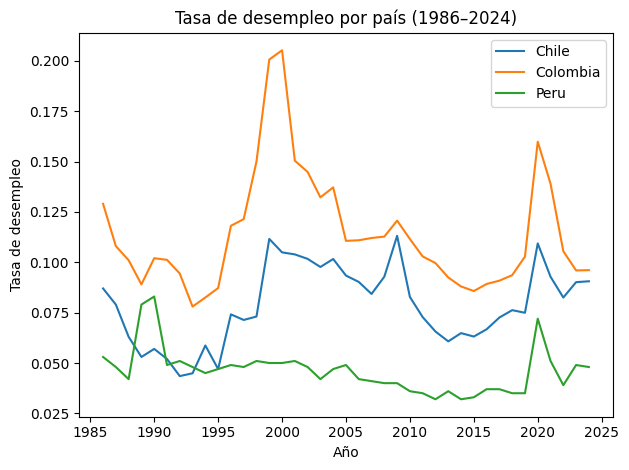

In [66]:
### GRAFICAS
import matplotlib.pyplot as plt


df_graf=pd.read_csv('panel_limpio.csv',sep=';')


# 1) Serie temporal por país
plt.figure()
for pais, g in df_graf.groupby('Pais'):
    g = g.sort_values('Anio')
    plt.plot(g['Anio'], g['Tasa_desempleo'], label=pais)
plt.xlabel('Año')
plt.ylabel('Tasa de desempleo')
plt.title('Tasa de desempleo por país (1986–2024)')
plt.legend()
plt.tight_layout()
plt.show()

Figura 1. Tasa de desempleo por país (1986–2024). “Se observan niveles estructuralmente distintos entre países y choques comunes en determinados años.”

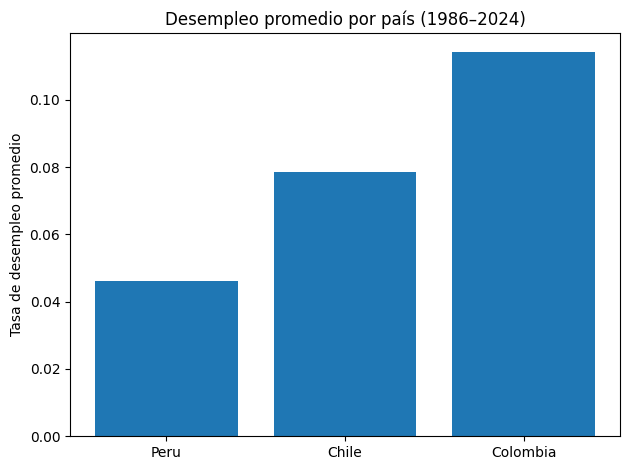

In [67]:
# 2) Barras comparativas (promedio por país)
means = df_graf.groupby('Pais')['Tasa_desempleo'].mean().sort_values()
plt.figure()
plt.bar(means.index, means.values)
plt.ylabel('Tasa de desempleo promedio')
plt.title('Desempleo promedio por país (1986–2024)')
plt.tight_layout()
plt.show()

Figura 2. Desempleo promedio por país. “Refuerza las diferencias transversales y motiva el uso de modelos de panel.”

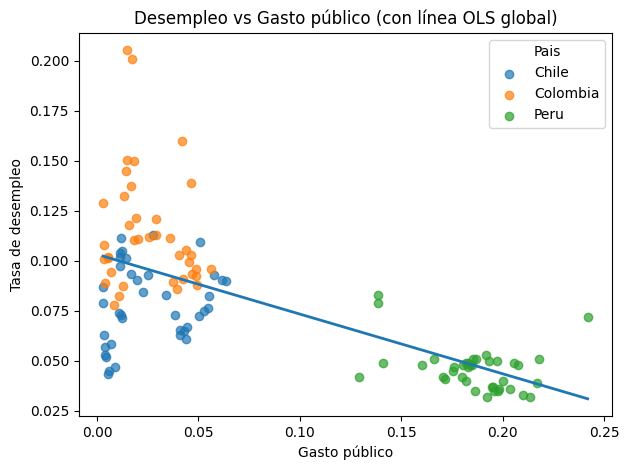

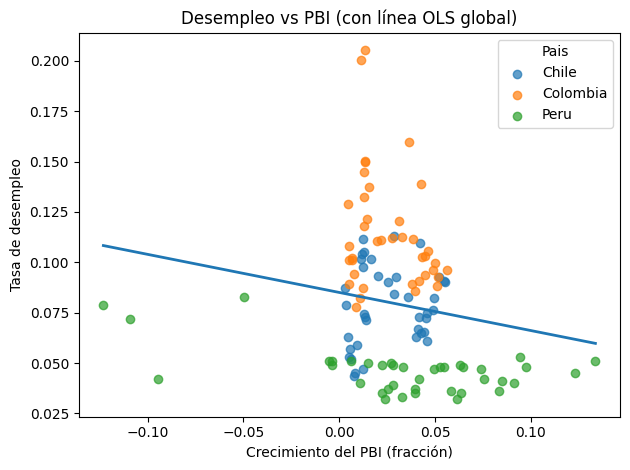

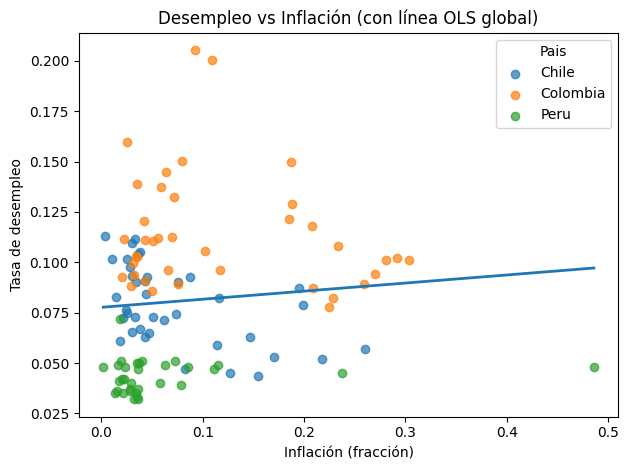

In [68]:

def scatter_with_ols_grouped(df_graf, xcol, ycol, xlab, ylab, title, groupcol='Pais'):
    plt.figure()
    # 1) puntos por país (cada grupo con su etiqueta en la leyenda)
    for g, sub in df_graf.groupby(groupcol):
        xg = sub[xcol].values
        yg = sub[ycol].values
        maskg = np.isfinite(xg) & np.isfinite(yg)
        if maskg.sum() > 0:
            plt.scatter(xg[maskg], yg[maskg], alpha=0.7, label=str(g))
    # 2) línea OLS global (sobre todos los puntos)
    x = df_graf[xcol].values
    y = df_graf[ycol].values
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() >= 2:
        m, b = np.polyfit(x[mask], y[mask], 1)
        xs = np.linspace(np.nanmin(x[mask]), np.nanmax(x[mask]), 200)
        plt.plot(xs, m*xs + b, linewidth=2)

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend(title=groupcol)
    plt.tight_layout()
    plt.show()


# 3) Desempleo vs Gasto público
scatter_with_ols_grouped(
    df_graf, 'Gasto_publico', 'Tasa_desempleo',
    'Gasto público', 'Tasa de desempleo',
    'Desempleo vs Gasto público (con línea OLS global)'
)

# 4) Desempleo vs PBI
scatter_with_ols_grouped(
    df_graf, 'PBI', 'Tasa_desempleo',
    'Crecimiento del PBI (fracción)', 'Tasa de desempleo',
    'Desempleo vs PBI (con línea OLS global)'
)



#Filtro para evitar datos inflados:
df_filtrado = df_graf[df_graf['Inflacion'] < 0.50]

# 5) Desempleo vs Inflación
scatter_with_ols_grouped(
    df_filtrado, 'Inflacion', 'Tasa_desempleo',
    'Inflación (fracción)', 'Tasa de desempleo',
    'Desempleo vs Inflación (con línea OLS global)'
)


Figura 3. Desempleo vs Gasto público. “Relación negativa marcada, consistente con el coeficiente RE significativo.”

Figura 4. Desempleo vs PBI. “Relación débil/no significativa en la muestra.”

Figura 5. Desempleo vs Inflación. “Asociación positiva marginal.”

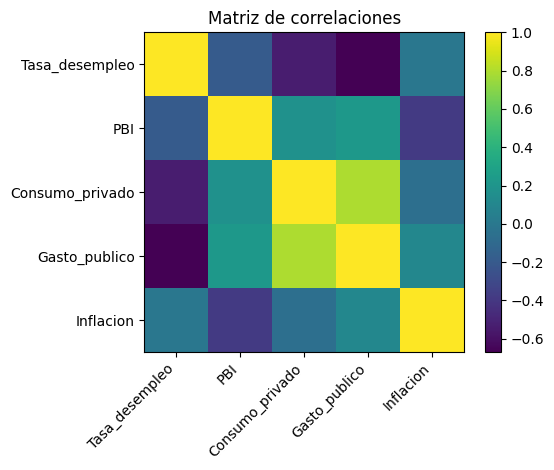

In [69]:
# 6) Matriz de correlaciones
import numpy as np
vars_corr = ['Tasa_desempleo','PBI','Consumo_privado','Gasto_publico','Inflacion']
corr = df_graf[vars_corr].corr()
plt.figure()
im = plt.imshow(corr, interpolation='nearest')
plt.xticks(ticks=np.arange(len(vars_corr)), labels=vars_corr, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(vars_corr)), labels=vars_corr)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Matriz de correlaciones')
plt.tight_layout()
plt.show()


Correlaciones. “Panorama de relaciones y chequeo de coherencia.”

### Pruebas Adicionales opcionales:

#### Prueba de normalidad

Ver si los errores $ \epsilon_{it}$ se distribuyen aproximadamente como una normal (N(0, σ²)).
Esto no afecta la consistencia, pero sí la validez de las pruebas t y F cuando la muestra es pequeña.

In [82]:
#### PRUEBA DE JARQUE-BERA test(JB)
from scipy.stats import jarque_bera
jb_stat, jb_pvalue = jarque_bera(res_fe.resids)
print(f"Jarque–Bera: {jb_stat:.3f}, p={jb_pvalue:.4f}")


Jarque–Bera: 4.004, p=0.1351


#### Multicolinealidad
Ver si las variables explicativas están altamente correlacionadas entre sí, lo cual infla las varianzas y hace que los coeficientes pierdan significancia (aunque el modelo global sí sea significativo).

In [83]:
### VIF (Variance Inflation Factor):
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['PBI','Consumo_privado','Gasto_publico','Inflacion', 'Inv_Extranjera_D', 'Salida_Net_Cap']].dropna()
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
for col, val in zip(X.columns, vif):
    print(col, "→ VIF:", round(val,2))


PBI → VIF: 2.42
Consumo_privado → VIF: 3.83
Gasto_publico → VIF: 6.04
Inflacion → VIF: 1.34
Inv_Extranjera_D → VIF: 5.55
Salida_Net_Cap → VIF: 6.63


- VIF < 5 → aceptable,
- 5–10 → precaución
- NO distorsiona significativamente los resultados.

- Se rechaza la homocedasticidad (varianza constante).
- Mantenemos el modelo RE con errores robustos o clusterizados.(“cov_type = 'robust'”)

### Resumen de estudios 

| Supuesto                     | Test                                    | Resultado           | Conclusión                                                                             |
| ---------------------------- | --------------------------------------- | ------------------- | -------------------------------------------------------------------------------------- |
| **Normalidad**               | Jarque–Bera                             | ✓ p = 0.1351 > 0.05 | Residuos aproximadamente normales. No se viola el supuesto.                            |
| **Autocorrelación**          | — *(no aplicado, modelo FE robusto DK)* | —                   | No se evalúa con Durbin–Watson; ya se corrige con Driscoll–Kraay.                      |
| **Multicolinealidad**        | VIF                                     | Máx = 6.63          | Leve multicolinealidad (aceptable). No requiere corrección.                            |
| **Heterocedasticidad**       | — *(modelo FE DK)*                      | —                   | No se aplica Breusch–Pagan; varianza no constante corregida por SE robustas.           |
| **Especificación funcional** | — *(RESET no válido para FE)*           | —                   | No aplica directamente. Modelo FE corrige forma funcional mediante efectos país y año. |



## Cloncusiones:

- Se estimó un modelo de panel con tres países (Chile, Colombia y Perú) y 39 años de observación (1986–2024) para explicar la tasa de desempleo en función de variables macroeconómicas: PBI, consumo privado, gasto público, inflación, inversión extranjera directa y salida neta de capital.

- Test de Hausman (χ²=20.61; p=0.0022) → se rechaza H₀, confirmando correlación entre efectos individuales y las variables explicativas.
⇒ Se prefiere el modelo de Efectos Fijos (FE) frente al de Efectos Aleatorios (RE).

- El modelo FE dos vías (país y año) resultó globalmente significativo (F=10.51; p<0.001), y fue estimado con errores Driscoll–Kraay, robustos a heterocedasticidad, autocorrelación y dependencia transversal.

- Entre las variables, solo la inflación mostró un efecto positivo y estadísticamente significativo sobre el desempleo (p<0.05), mientras que PBI, gasto público, consumo privado, IED y salida neta de capital no presentaron efectos significativos dentro de cada país en el tiempo.

- El R² dentro (0.115) indica un poder explicativo moderado, adecuado para un panel pequeño (N=3). Los resultados del F-test de poolabilidad (p<0.001) confirman la necesidad de mantener los efectos fijos por país y año.

- El análisis evidencia que las diferencias estructurales entre países y periodos influyen significativamente en el desempleo, por lo que el modelo de efectos fijos con corrección Driscoll–Kraay es el más apropiado. La inflación se identifica como el principal factor asociado a la variación del desempleo, mientras que las demás variables no muestran influencia estadísticamente significativa en el marco del modelo.